In [5]:
library('quantmod')
library('xts')
library('ggplot2')
library('tseries')
library('depmixS4')
set.seed(1)

Warning message:
"package 'depmixS4' was built under R version 3.5.2"Loading required package: nnet
Loading required package: MASS
Loading required package: Rsolnp
Warning message:
"package 'Rsolnp' was built under R version 3.5.2"

In [6]:
getSymbols("^GSPC", from = "2015-01-01" , to = as.character(Sys.Date()))
GSPC <- na.omit(GSPC)

getSymbols("^KS11", from = "2015-01-01" , to = as.character(Sys.Date()))
KS11 <-na.omit(KS11)

'getSymbols' currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
'loadSymbols' to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.


Please see the Warning section of '?getSymbols.yahoo' for details.

This message is shown once per session and may be disabled by setting
options("getSymbols.yahoo.warning"=FALSE).


[1] "GSPC"

Warning message:
"^KS11 contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."

[1] "KS11"

In [7]:
getPeriod <- function(symbol,e_date,s_date,type){
    e_daten <- as.numeric(as.Date(e_date))
    s_daten <- as.numeric(as.Date(s_date))
    period <- e_daten:s_daten
    
    Isymbol <- index(type(symbol))
    Dsymbol <- coredata(type(symbol))
    Isymboln <- as.numeric(Isymbol)
    Date <- c()
    Price <- c()
    
    for (i in 1:length(period)){
        n <- which(Isymboln == period[i])
        Date <- c(Date, Isymboln[n])
        Price <- c(Price, Dsymbol[n])
        
    }
    return(cbind(Date,Price))
}

getPairPeriod <- function(A,B){
    result <- c()
    
    for (i in 1:length(A[,1])){
        n <- which(A[i,1]== B[,1])
        
        if (any(n>0)){
            Date <- B[n,1]
            PriceA <- A[i,2]
            PriceB <- B[n,2]
            result <- rbind(result, c(Date, PriceA, PriceB))
        }
    }
    return(result)
    
}

getSRB <- function(A,B){
    Pair <- getPairPeriod(A,B)
    
    logA <- log(Pair[,2])
    logB <- log(Pair[,3])
    VarB <- var(logB)
    CovAB <- cov(logA,logB)
    result <- CovAB/VarB
    return(result)
}

getCC <- function(A,B){
    Pair <- getPairPeriod(A,B)
    logA <- log((Pair[,2]))
    logB <- log((Pair[,3]))
    
    result <- c()
    
    for (i in 1:2000*0.001){
        test <- adf.test(logA-i*logB)
        result <- rbind(result,c(test$p.value,i))    
    }
    n <- which(result[,1] == min(result[,1]))
    #result$p.value <- result[n,1]
    resultg <- result[n,2]
    return(resultg)
}

getSpread <- function(A,B,type){
    Pair <- getPairPeriod(A,B)
    NPIA <- (Pair[,2]-mean(Pair[,2]))/sd(Pair[,2])
    NPIB <- (Pair[,3]-mean(Pair[,3]))/sd(Pair[,3])
    h <- type(A,B)
    result <- NPIA-h*NPIB
    return(result)
}

getSpreadPlot <- function(A,B,type){
    s <- getSpread(A,B,type)
    beta <- type(A,B)
    ADF <- adf.test(s)
    pv <- ADF$p.value
    Pair <- getPairPeriod(A,B)
    date <- as.Date(Pair[,1])
    upper <- rep(1.5*sd(s),length(s))
    lower <- rep(-1.5*sd(s), length(s))
    Spread <- xts(s, order.by = date)
    
    ggplot(Spread, aes(x=date,y=s))+geom_line(color="blue")+ggtitle("Spread Chart", subtitle = as.character(beta))+
    xlab(as.character(pv))+    ylab("")+geom_hline(yintercept=0,color = "green")+geom_hline(yintercept = upper, color = "red")+
    geom_hline(yintercept = lower, color = "red")#+ coord_fixed(ratio = 150)
    
    
}

getHMM <- function(A,n){
    data <- A[,2]
    returns <- diff(log(data))
    hmm <- depmix(returns ~1, family = gaussian(), nstates = n, data = data.frame(returns=returns))
    hmmfit <- fit(hmm, verbose = FALSE, emc=em.control(random.start=TRUE))
    post_probs <- posterior(hmmfit)
    
    Data <- post_probs[-1]
    d <- A[,1]
    dd <- d[2:length(d)]
    date <- as.Date(dd)
    
    TS <- xts(Data, order.by = date)
    
    
    #ggplot(TS, aes(x=date,y=S1, colour = S2))+geom_line()+ggtitle("Spread Chart", subtitle = "")+xlab("")+
    #ylab("")
    
    layout(1:2)
    matplot(Data, type = "l", main = "Regime Posterior Probabilities(Full)", ylab = "")
    legend(x = "bottomleft", c("State1","State2"), fill = 1:2, bty = n)
    matplot(Data[90:length(Data[,1]),], type = "l", main = "Regime Posterior Probabilities(Recent)", ylab = "")
    legend(x = "bottomleft", c("State1","State2"), fill = 1:3, bty = n)
    
    summary(hmmfit, which="response")
    print(post_probs[length(post_probs[,1]),])
    
    
}

getChart <- function(A){
    data <- A[,2]
    date <- as.Date(A[,1])
    TS <- xts(data, order.by = date)
    layout(1:2)
    ggplot(TS, aes(x=date,y=data))+geom_line(color="blue")+ggtitle("KOSPI", subtitle = "")+xlab("")+
    ylab("")
    
}

In [8]:
snp = getPeriod(GSPC,as.character(Sys.Date()-180),as.character(Sys.Date()-1),Cl)

kospi = getPeriod(KS11,as.character(Sys.Date()-180),as.character(Sys.Date()-1),Cl)

converged at iteration 90 with logLik: 380.6366 
Response parameters 
Resp 1 : gaussian 
    Re1.(Intercept) Re1.sd
St1           0.001  0.007
St2          -0.005  0.015
    state        S1        S2
116     1 0.9832008 0.0167992


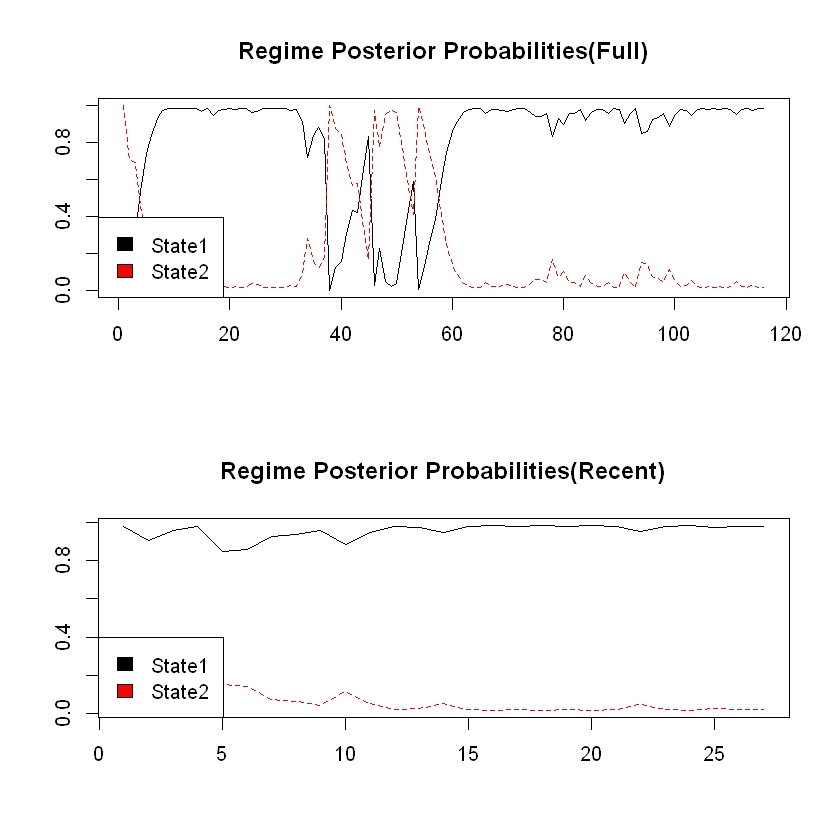

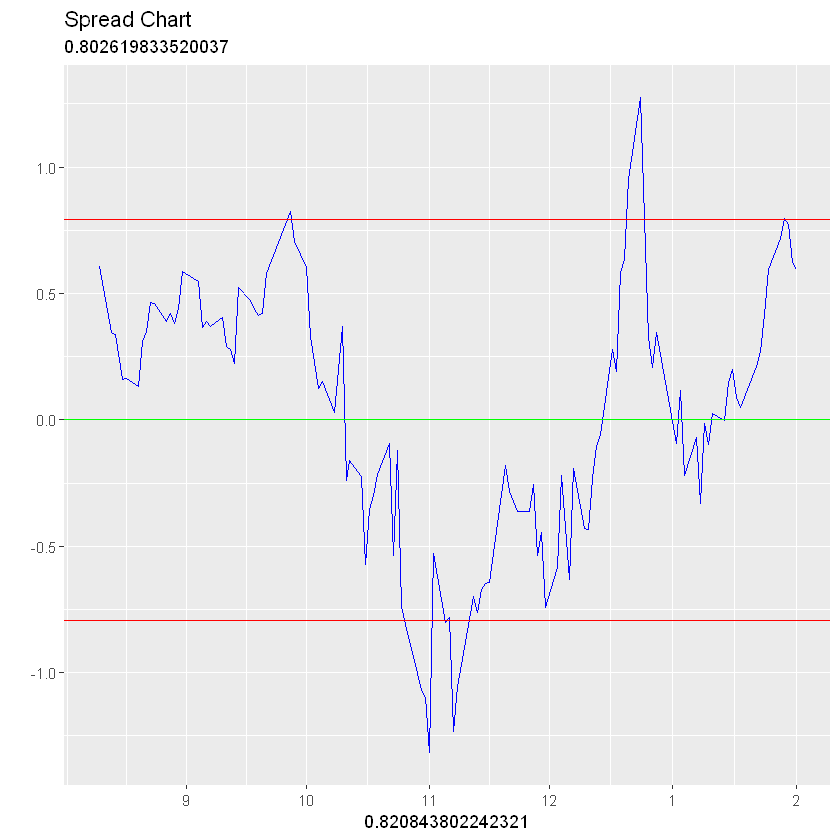

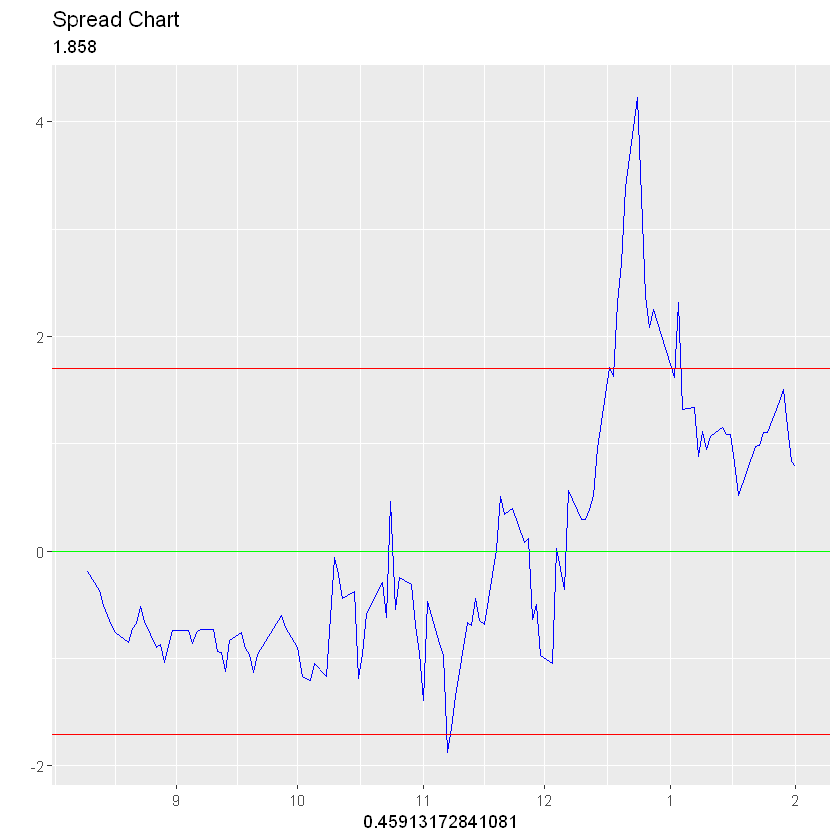

In [11]:
#getChart(kospi)

getHMM(kospi,2)
getSpreadPlot(kospi,snp,getSRB)
getSpreadPlot(kospi,snp,getCC)